### Sift descriptor with bag-of-words

---

In this notebook I use sift descriptor to descrive the image, than I use kmeans to cluster this descriptors. The idea is that each cluster will be representing a visual word, if an image is added then the SIFT descriptor will be used to describe the image followed by kmeans prediction that will tell wich word represents each SIFT vector that describes the image.

Than finally I count the ocorrences of each visual word, by doing so, creating an histogram.
 
---

In [1]:
!gdown 1qEFqKDJjYgMW1HvW1KBIzvv_MNRD2ZV4
!gdown 1-3wxjeuzHj8owIX2w8CECMEAFhKCviab

Downloading...
From: https://drive.google.com/uc?id=1qEFqKDJjYgMW1HvW1KBIzvv_MNRD2ZV4
To: /content/celeb_data_resized.csv
100% 1.03M/1.03M [00:00<00:00, 88.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3wxjeuzHj8owIX2w8CECMEAFhKCviab
To: /content/celeb_data_resized.zip
100% 671M/671M [00:05<00:00, 134MB/s]


In [2]:
%%capture
!unzip celeb_data_resized.zip 

In [3]:
%%capture
!pip install -U opencv-python

In [4]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from random import randrange
from skimage import io
from PIL import Image 
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import feature



In [5]:
## parans ##
sampling_pixels = 8
radius = 1

In [6]:
df = pd.read_csv('celeb_data_resized.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.iloc[:3000]
df.head(1)

,img_location,x0,y0,x1,y2
0,celeb_data_resized/000001.jpg,111.49144,49.606987,376.723694,268.296936


In [7]:
def get_lbp(img):
  return feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")

In [8]:
# feature_extractor = cv2.SIFT_create()

In [9]:
L_LPB = []

for imagem in tqdm(df['img_location']):
  imagem_data = io.imread(imagem) 
  imagem_data = cv2.cvtColor(imagem_data, cv2.COLOR_BGR2GRAY)
  LBP_vectors = get_lbp(imagem_data)
  L_LPB.append(LBP_vectors)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [10]:
def draw_bounding_box(face_coordinates, image_array, color):
    x1, y1, x2, y2 = [int(i) for i in face_coordinates]
    cv2.rectangle(image_array, (x1, y1), (x2, y2), color, 2)
    cv2_imshow( image_array)


In [11]:
df['lbp'] = L_LPB

## Agrupamento dos descritores SIFT para geração de Visual Words

In [12]:
X_sift = []
for _, row in df.iterrows():
  for sift_vector in row['lbp']:
    X_sift.append(sift_vector)

In [13]:
X_sift = np.array(X_sift)
X_sift.shape

(1440000, 480)

## Agrupamento de descritores

O número de bag of visual words descreverá o número de palavras visuais.

In [14]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import numpy as np

In [15]:
num_visual_words = 512
kmeans = MiniBatchKMeans(n_clusters=num_visual_words, n_init=1, max_iter=20, init='random', verbose=1)
kmeans.fit(X_sift)

Init 1/1 with method random
Inertia for init 1/1: 10325131.0
[MiniBatchKMeans] Reassigning 469 cluster centers.
Minibatch step 1/28125: mean batch inertia: 3354.400390625
Minibatch step 2/28125: mean batch inertia: 2407.801292763188, ewa inertia: 2407.801292763188
Minibatch step 3/28125: mean batch inertia: 2416.5343014924474, ewa inertia: 2407.8137130336445
Minibatch step 4/28125: mean batch inertia: 2374.3022640501217, ewa inertia: 2407.766052339299
Minibatch step 5/28125: mean batch inertia: 2430.7918613618467, ewa inertia: 2407.798800133834
[MiniBatchKMeans] Reassigning 486 cluster centers.
Minibatch step 6/28125: mean batch inertia: 2397.1111218830774, ewa inertia: 2407.7835998908777
Minibatch step 7/28125: mean batch inertia: 2410.3723417801016, ewa inertia: 2407.7872816545637
Minibatch step 8/28125: mean batch inertia: 2392.662357449709, ewa inertia: 2407.7657706661885
Minibatch step 9/28125: mean batch inertia: 2431.749854190741, ewa inertia: 2407.7998813390686
Minibatch step 1

MiniBatchKMeans(init='random', max_iter=20, n_clusters=512, n_init=1, verbose=1)

In [16]:
import pickle

filename = 'kmeans_model_for_BOVW_clustering.sav'
pickle.dump(kmeans, open(filename, 'wb'))

In [17]:
loaded_model = pickle.load(open(filename, 'rb'))

In [18]:
df_visual_words = pd.DataFrame(X_sift)
df_visual_words.head(1)

,0,1,2,3,4,5,6,7,8,9,...,470,471,472,473,474,475,476,477,478,479
0,3.0,5.0,5.0,3.0,5.0,3.0,5.0,5.0,5.0,5.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0


In [19]:
df_visual_words['visual_word'] = kmeans.labels_
df_visual_words.head(5)

,0,1,2,3,4,5,6,7,8,9,...,471,472,473,474,475,476,477,478,479,visual_word
0,3.0,5.0,5.0,3.0,5.0,3.0,5.0,5.0,5.0,5.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0,254
1,5.0,8.0,8.0,5.0,8.0,5.0,8.0,8.0,8.0,8.0,...,7.0,3.0,3.0,8.0,8.0,8.0,8.0,8.0,5.0,207
2,5.0,8.0,8.0,7.0,3.0,5.0,8.0,8.0,8.0,8.0,...,9.0,5.0,5.0,7.0,8.0,8.0,8.0,8.0,5.0,289
3,5.0,8.0,8.0,8.0,5.0,5.0,8.0,8.0,8.0,8.0,...,9.0,8.0,8.0,5.0,8.0,8.0,8.0,8.0,5.0,329
4,5.0,8.0,8.0,8.0,5.0,7.0,3.0,8.0,8.0,3.0,...,1.0,9.0,5.0,7.0,8.0,7.0,5.0,5.0,3.0,207


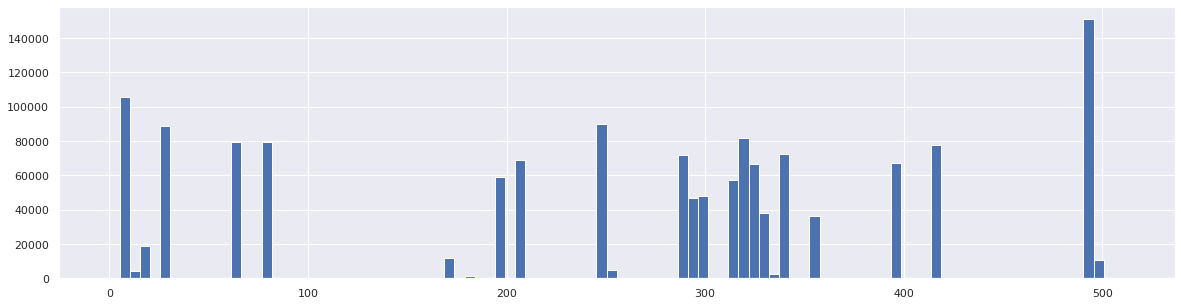

In [20]:
import seaborn as sns

sns.set_theme()

plt.rcParams["figure.figsize"] = (20,5)
df_visual_words.visual_word.hist(bins=100)

## Now we need to generate the histogram of each image based on the "words" that describes the image

In [22]:
L_histogram = []
for index,row in tqdm(df.iterrows(),total=len(df)):
  histogram = kmeans.predict(np.array(row['lbp']))
  histogram = np.histogram(histogram,num_visual_words)[0]
  L_histogram.append(histogram)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [23]:
df['visual_words_histogram'] = L_histogram
df.head()

,img_location,x0,y0,x1,y2,lbp,visual_words_histogram
0,celeb_data_resized/000001.jpg,111.491440,49.606987,376.723694,268.296936,"[[3.0, 5.0, 5.0, 3.0, 5.0, 3.0, 5.0, 5.0, 5.0,...","[50, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,celeb_data_resized/000002.jpg,81.702126,75.959595,332.482269,323.232330,"[[3.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0,...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,celeb_data_resized/000003.jpg,207.360001,100.782913,294.720001,316.014221,"[[3.0, 0.0, 5.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0,...","[1, 0, 0, 0, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,celeb_data_resized/000004.jpg,181.165054,50.064934,345.436920,202.207794,"[[1.0, 9.0, 1.0, 9.0, 9.0, 9.0, 2.0, 0.0, 5.0,...","[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,celeb_data_resized/000005.jpg,185.704926,63.341404,280.131134,159.806305,"[[1.0, 3.0, 5.0, 9.0, 1.0, 5.0, 3.0, 1.0, 5.0,...","[9, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [26]:
df.rename(columns={'y2':'y1'},inplace=True)

In [27]:
df[['img_location', 'x0', 'y0', 'x1', 'y1', 'visual_words_histogram']].to_csv('lbp_celeb_with_visual_words.csv', index=False)

In [30]:
df[['img_location', 'x0', 'y0', 'x1', 'y1', 'visual_words_histogram']].to_pickle('lbp_celeb_with_visual_words.pkl')


In [24]:
df['visual_words_histogram'] = [list(cur_hist) for cur_hist in df['visual_words_histogram']] 

In [ ]:
df['visual_words_histogram'] = df['visual_words_histogram'].apply(lambda x: list(np.array(x)/len(x)))

In [ ]:
np.sum(df['visual_words_histogram'].values, axis=-1) 

In [ ]:
df[['img_location', 'x0', 'y0', 'x1', 'y1', 'visual_words_histogram']].to_csv('celeb_with_visual_words.csv', index=False)

In [ ]:
test_df = pd.read_csv('celeb_with_visual_words.csv')